<a href="https://colab.research.google.com/github/hsudhakaran/test_jax/blob/main/Jax_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

from jax import pmap
from jax import random



In [3]:
def f(x):
    return 4*x**3 + 3*x**2 + 2*x + 1
jax.make_jaxpr(f)(2.0)

{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=3] a
    c:f32[] = mul 4.0 b
    d:f32[] = integer_pow[y=2] a
    e:f32[] = mul 3.0 d
    f:f32[] = add c e
    g:f32[] = mul 2.0 a
    h:f32[] = add f g
    i:f32[] = add h 1.0
  in (i,) }

In [4]:
grad_f = jax.grad(f)
jax.make_jaxpr(grad_f)(2.0)

{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=3] a
    c:f32[] = integer_pow[y=2] a
    d:f32[] = mul 3.0 c
    e:f32[] = mul 4.0 b
    f:f32[] = integer_pow[y=2] a
    g:f32[] = integer_pow[y=1] a
    h:f32[] = mul 2.0 g
    i:f32[] = mul 3.0 f
    j:f32[] = add e i
    k:f32[] = mul 2.0 a
    l:f32[] = add j k
    _:f32[] = add l 1.0
    m:f32[] = mul 2.0 1.0
    n:f32[] = mul 3.0 1.0
    o:f32[] = mul n h
    p:f32[] = add_any m o
    q:f32[] = mul 4.0 1.0
    r:f32[] = mul q d
    s:f32[] = add_any p r
  in (s,) }

In [5]:
jax.grad(f)(2.0)

Array(62., dtype=float32, weak_type=True)

In [6]:
def matrix_mul(a, b):
    return jnp.matmul(a, b)
key = jax.random.PRNGKey(42)
a = jax.random.normal(key, shape=(1000, 5000))
b = jax.random.normal(key, shape=(5000, 1000))
jax.make_jaxpr(matrix_mul)(a, b)

{ lambda ; a:f32[1000,5000] b:f32[5000,1000]. let
    c:f32[1000,1000] = dot_general[dimension_numbers=(([1], [0]), ([], []))] a b
  in (c,) }

In [7]:
# Normal computation
%timeit -n5 matrix_mul(a, b).block_until_ready()

The slowest run took 22.14 times longer than the fastest. This could mean that an intermediate result is being cached.
12.8 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [8]:
jit_matrix_mul = jax.jit(matrix_mul)
jax.make_jaxpr(jit_matrix_mul)(a, b)

{ lambda ; a:f32[1000,5000] b:f32[5000,1000]. let
    c:f32[1000,1000] = pjit[
      jaxpr={ lambda ; d:f32[1000,5000] e:f32[5000,1000]. let
          f:f32[1000,1000] = dot_general[
            dimension_numbers=(([1], [0]), ([], []))
          ] d e
        in (f,) }
      name=matrix_mul
    ] a b
  in (c,) }

In [9]:
# warmup
warmup_results = jit_matrix_mul(a, b)
# ⚡️ speed em up!
%timeit -n5 jit_matrix_mul(a, b).block_until_ready()

2.38 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [10]:
def f_def(x):
    return x*x

g_def = jax.vmap(f_def)
x_test = jnp.array([2,4,6])
%timeit -n5 g_def(a).block_until_ready()
jitted_g = jax.jit(g_def)
jitted_g(b)
%timeit -n5 jitted_g(a).block_until_ready()

The slowest run took 18.12 times longer than the fastest. This could mean that an intermediate result is being cached.
3.67 ms ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 23.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1.4 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [11]:
jax.device_count(), jax.devices()

(2, [gpu(id=0), gpu(id=1)])

In [12]:
key = random.PRNGKey(42)
a = random.normal(key, shape=(3000,5000))
b = random.normal(key, shape=(5000,3000))
matrix_mul = lambda a, b: jnp.matmul(a, b)
matrix_mul(a, b).shape

(3000, 3000)

In [13]:
n_devices = jax.local_device_count()
a = random.normal(key, shape=(n_devices, 3000, 5000))
b = random.normal(key, shape=(n_devices, 5000, 3000))
parallel_matrix_mul = pmap(matrix_mul)
parallel_matrix_mul(a, b).shape

(2, 3000, 3000)

In [14]:
matrix_mul(a, b)[0].shape

(3000, 3000)

In [15]:
parallel_matrix_mul(a, b)[0].shape

(3000, 3000)

In [16]:
jnp.array_equal(matrix_mul(a, b), parallel_matrix_mul(a, b)[0], equal_nan=True)

Array(False, dtype=bool)

In [17]:
key = jax.random.PRNGKey(42)
xs = random.normal(key, shape=(1,))
ys = random.normal(key+42, shape=(1,))

xs,ys

(Array([-0.18471177], dtype=float32), Array([0.4362823], dtype=float32))

In [18]:
# Build the PRNG key
key = jax.random.PRNGKey(42)
xs = random.normal(key, shape=(128, 1))
# Hyperparameters for the linear function
m = 2.0
c = 4.0
# Build the linear function
ys = (m*xs) + c

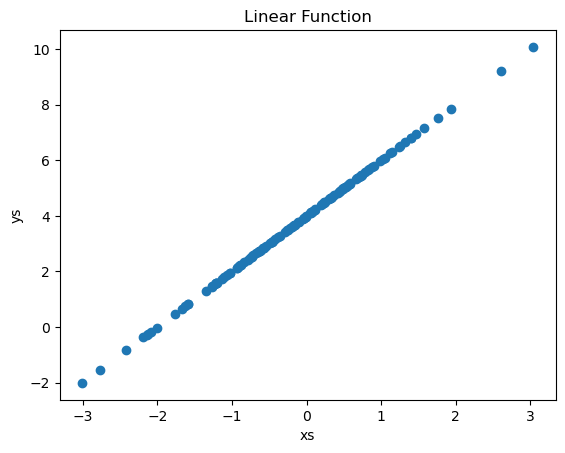

In [19]:
# Visualizing the function
plt.scatter(xs, ys)
plt.xlabel("xs")
plt.ylabel("ys")
plt.title("Linear Function")
plt.show()

In [20]:
def linear_model(theta, x):
    """
    The linear model that will fit on the linear function.
    Args:
        - theta: Collection of weights and biases.
        - x: The input to the model.
    
    Returns:
        The prediction from the model.
    """
    weight, bias = theta
    pred = x * weight + bias
    return pred

In [21]:
def get_loss(theta, x, y):
    """
    The loss function. We use the L2 distance as our loss function.
    Args:
        - theta: Parameters of the model.
        - x: Input to the model.
        - y: The ground truth of the dataset.
    
    Returns:
        A scalar loss between the ground truth and the predicted value.
    """
    pred = linear_model(theta, x)
    loss = jnp.mean((y - pred)**2)
    return loss

In [22]:
@jax.jit
def update_step(theta, x, y, lr):
    """
    A single update step for our model. We use the simple stochastic
    gradient update as our optimizer.
    Args:
        - theta: Parameters of the model.
        - x: Input to the model.
        - y: The ground truth of the dataset.
        - lr: Learning rate of the optimizer.
    
    Returns:
        - The current updated state of the model parameters.
        - The current loss
    """
    loss, gradient = jax.value_and_grad(get_loss)(theta, x, y)
    updated_theta = theta - lr * gradient
    return updated_theta, loss

In [23]:
weight = 0.0
bias = 0.0
theta = jnp.array([weight, bias])

epochs = 20000
for iter in range(epochs):
    theta, loss = update_step(theta, xs, ys, 1e-4)
    if iter % 2000 == 0 and iter != 0:
        print(f"ITER {iter} | LOSS {loss:.4f}")

ITER 2000 | LOSS 8.7530
ITER 4000 | LOSS 4.2608
ITER 6000 | LOSS 2.0763
ITER 8000 | LOSS 1.0126
ITER 10000 | LOSS 0.4942
ITER 12000 | LOSS 0.2413
ITER 14000 | LOSS 0.1179
ITER 16000 | LOSS 0.0576
ITER 18000 | LOSS 0.0281


In [24]:
theta

Array([1.9335481, 3.8952863], dtype=float32)

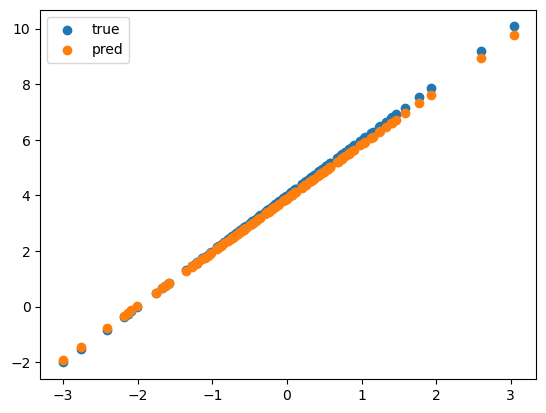

In [25]:
plt.scatter(xs, ys, label="true")
plt.scatter(xs, linear_model(theta, xs), label="pred")
plt.legend()
plt.show()

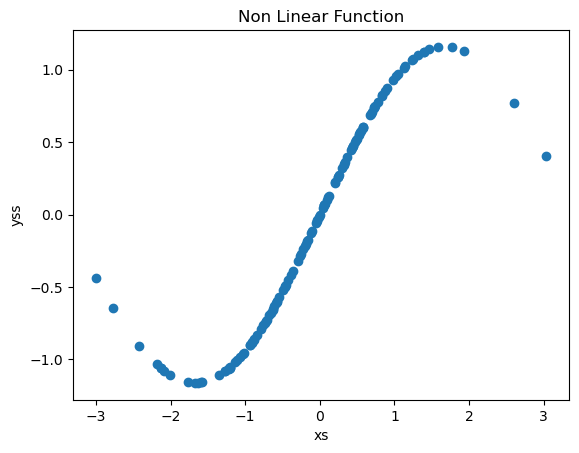

In [26]:
mu = 0.0
sigma = 0.1
noise = mu + sigma * random.normal(key, shape=xs.shape)
yss = jnp.sin(xs) + noise
plt.scatter(xs, yss)
plt.xlabel("xs")
plt.ylabel("yss")
plt.title("Non Linear Function")
plt.show()

In [27]:
def nonlinear_model(theta, x):
    """
    The non-linear model that will fit on the non-linear function.
    Args:
        - theta: Collection of weights and biases.
        - x: The input to the model.
    
    Returns:
        The prediction from the model.
    """
    weight1, weight2, bias1, bias2 = theta
    inter_output = (x * weight1) + bias1
    pred = (jax.nn.relu(inter_output) * weight2) + bias2
    return pred

In [28]:
def get_loss(theta, x, y):
    """
    The loss function. We use the L1 distance as our loss function.
    Args:
        - theta: Parameters of the model.
        - x: Input to the model.
        - y: The ground truth of the dataset.
    
    Returns:
        A scalar loss between the ground truth and the predicted value.
    """
    pred = nonlinear_model(theta, x)
    loss = jnp.mean((y - pred)**2)
    return loss

In [29]:
@jax.jit
def update_step(theta, x, y, lr):
    """
    A single update step for our model. We use the simple stochastic
    gradient update as our optimizer.
    Args:
        - theta: Parameters of the model.
        - x: Input to the model.
        - y: The ground truth of the dataset.
        - lr: Learning rate of the optimizer.
    
    Returns:
        - The current updated state of the model parameters.
        - The current loss
    """
    loss, gradient = jax.value_and_grad(get_loss)(theta, x, y)
    updated_theta = theta - lr * gradient
    return updated_theta, loss

In [30]:
# Initialize the parameters of the model
theta = jnp.array([1.0, 1.0, 1.0, 1.0])
# Iterate and update the parameters
epochs = 200000
for iter in range(epochs):
    theta, loss = update_step(theta, xs, yss, 1e-4)
    if iter % 20000 == 0 and iter != 0:
        print(f"ITER {iter} | LOSS {loss:.4f}")

ITER 20000 | LOSS 0.1291
ITER 40000 | LOSS 0.0837
ITER 60000 | LOSS 0.0703
ITER 80000 | LOSS 0.0648
ITER 100000 | LOSS 0.0625
ITER 120000 | LOSS 0.0614
ITER 140000 | LOSS 0.0610
ITER 160000 | LOSS 0.0609
ITER 180000 | LOSS 0.0608


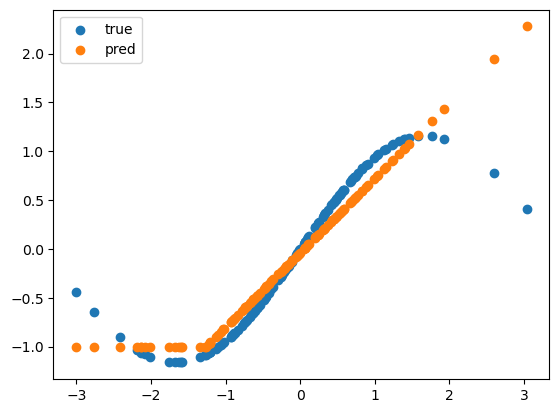

In [31]:
plt.scatter(xs, yss, label="true")
plt.scatter(xs, nonlinear_model(theta, xs), label="pred")
plt.legend()
plt.show()

In [32]:
theta

Array([ 0.8375902,  0.9096197,  1.0616809, -1.0030999], dtype=float32)

In [33]:
def init_mlp_params(layer_widths):
    """
    Function to initialize the parameters of a Multilayer Perceptron.
    Args:
        - layer_widths: The list of layer widths.
    
    Returns:
        Randomly initialized parameters of the model.
    """
    key = random.PRNGKey(42)
    
    # params of the MLP will be a pytree
    params = []
    for number_in, number_out in zip(layer_widths[:-1], layer_widths[1:]):
        key, subkey = random.split(key)
        params.append(
            dict(
                weights=random.normal(subkey, shape=(number_in, number_out)) * jnp.sqrt(2/number_in),
                biases=jnp.ones(shape=(number_out,))
            )
        )
    return params

In [34]:
# Initialize the parameters of the MLP
params = init_mlp_params([1, 128, 128, 1])
# Custom function to get shape
get_shape = lambda x:x.shape
shape_pytree = jax.tree_map(get_shape, params)
for idx, layer in enumerate(shape_pytree):
    print(f"Layer {idx}")
    print(layer)

Layer 0
{'biases': (128,), 'weights': (1, 128)}
Layer 1
{'biases': (128,), 'weights': (128, 128)}
Layer 2
{'biases': (1,), 'weights': (128, 1)}


In [35]:
len(jax.tree_util.tree_leaves(params[0]))

2

In [36]:
type(params[0]['weights'])

jaxlib.xla_extension.ArrayImpl

In [37]:
def forward(params, x):
    """
    The forward propagation step.
    Args:
        - params: The parameters of the model.
        - x: The input to the model.
    
    Returns:
        Prediction from the model.
    """
    # Get the hidden layers and the last layer separately.
    *hidden, last = params
    # Iterate over the hidden layers and forward propagate the
    # input through the layers.
    for layer in hidden:
        x = jax.nn.relu(x @ layer["weights"] + layer["biases"])
    # Get the prediction
    pred = x @ last["weights"] + last["biases"]
    return pred

In [38]:
def get_loss(params, x, y):
    """
    The loss function. We use the L2 distance as our loss function.
    Args:
        - params: Parameters of the model.
        - x: Input to the model.
        - y: The ground truth of the dataset.
    
    Returns:
        A scalar loss between the ground truth and the predicted value.
    """
    pred = forward(params, x)
    loss = jnp.mean((pred - y) ** 2)
    return loss

In [39]:
@jax.jit
def update_step(params, x, y, lr):
    """
    A single update step for our model. We use the simple stochastic
    gradient update as our optimizer.
    Args:
        - params: Parameters of the model.
        - x: Input to the model.
        - y: The ground truth of the dataset.
        - lr: Learning rate of the optimizer.
    
    Returns:
        - The current updated state of the model parameters.
        - The current loss
    """
    loss, gradients = jax.value_and_grad(get_loss)(params, x, y)
    sgd = lambda param, gradient: param - lr * gradient
    updated_params = jax.tree_map(
        sgd, params, gradients
    )
    return updated_params, loss

In [40]:
epochs = 10000
for iter in range(epochs):
    params, loss = update_step(params, xs, yss, 1e-5)
    if iter % 1000 == 0 and iter != 0:
        print(f"ITER {iter} | LOSS {loss:.4f}")

ITER 1000 | LOSS 0.1039
ITER 2000 | LOSS 0.0616
ITER 3000 | LOSS 0.0427
ITER 4000 | LOSS 0.0331
ITER 5000 | LOSS 0.0275
ITER 6000 | LOSS 0.0238
ITER 7000 | LOSS 0.0212
ITER 8000 | LOSS 0.0192
ITER 9000 | LOSS 0.0177


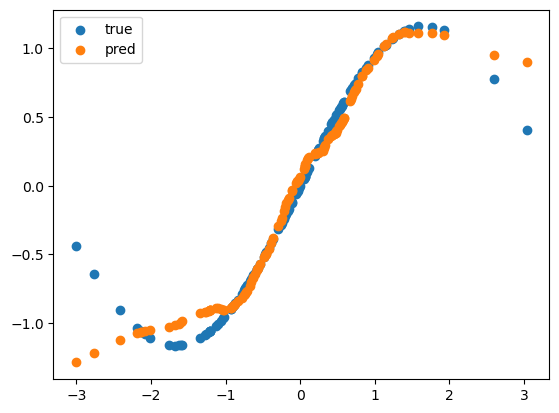

In [41]:
plt.scatter(xs, yss, label="true")
plt.scatter(xs, forward(params, xs), label="pred")
plt.legend()
plt.show()